In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats

In [36]:
#data = pd.read_csv('../Data/LT_DU_data_for_ML.csv') #Mix of ordinal and One Hot encoding
data = pd.read_csv('../Data/LT_DU_data_for_ML_all_OneHot.csv') # all features encoded with One Hot 
data.columns

Index(['lpk', 'hourly_rate', 'esize_class_orig', 'esize_class_1_49',
       'esize_class_50_249', 'esize_class_GT_250', 'gender_orig', 'gender_M',
       'age_class_orig', 'age_class_14-29', 'age_class_30-39',
       'age_class_40-49', 'age_class_50-59', 'age_class_60+', 'education_orig',
       'education_G1', 'education_G2', 'education_G3', 'education_G4', 'lpk1',
       'lpk2', 'lpk1_nc', 'outlier', 'nace_orig', 'nace_B', 'nace_C', 'nace_D',
       'nace_E', 'nace_F', 'nace_G', 'nace_H', 'nace_I', 'nace_J', 'nace_K',
       'nace_L', 'nace_M', 'nace_N', 'nace_O', 'nace_P', 'nace_Q', 'nace_R',
       'nace_S'],
      dtype='object')

## Data selection and filtering

Select lpk level

In [37]:
lpk_level = 'lpk1'
#Valid options: 'lpk', 'lpk1', 'lpk2', 'lpk1_nc'

Include outliers?

In [38]:
remove_outliers = True
if remove_outliers == True:
    data=data.query('outlier==False')
    print('Outliers removed')
else:
    print('Outliers retained')

data.shape

Outliers removed


(35170, 42)

Include upper boundary?

In [39]:
upper_boundary = 15
remove_above_boundary = False
if remove_above_boundary == True:
    data=data.query('hourly_rate <= @upper_boundary')
    print('"hourly_rate" values above boundary are removed')
else:
    print('All records retained')

data.shape

All records retained


(35170, 42)

Remove below minimal wage?

In [40]:
lower_boundary = 2.45
remove_below_boundary = False
if remove_below_boundary == True:
    data=data.query('hourly_rate >= @lower_boundary')
    print('"hourly_rate" values belove boundary are removed')
else:
    print('All records retained')

data.shape

All records retained


(35170, 42)

Prepare X and y

In [41]:
remove_col = ['lpk', 'lpk1', 'lpk2', 'lpk1_nc', 'outlier',
             'nace_orig','esize_class_orig','gender_orig','age_class_orig','education_orig']
remove_col.remove(lpk_level)

In [42]:
data_sf = pd.get_dummies(data, prefix=lpk_level ,columns=[lpk_level])
data_sf.drop(columns=remove_col, inplace=True )
data_sf.columns

Index(['hourly_rate', 'esize_class_1_49', 'esize_class_50_249',
       'esize_class_GT_250', 'gender_M', 'age_class_14-29', 'age_class_30-39',
       'age_class_40-49', 'age_class_50-59', 'age_class_60+', 'education_G1',
       'education_G2', 'education_G3', 'education_G4', 'nace_B', 'nace_C',
       'nace_D', 'nace_E', 'nace_F', 'nace_G', 'nace_H', 'nace_I', 'nace_J',
       'nace_K', 'nace_L', 'nace_M', 'nace_N', 'nace_O', 'nace_P', 'nace_Q',
       'nace_R', 'nace_S', 'lpk1_1', 'lpk1_2', 'lpk1_3', 'lpk1_4', 'lpk1_5',
       'lpk1_7', 'lpk1_8', 'lpk1_9'],
      dtype='object')

In [43]:
y = data_sf['hourly_rate']
X = data_sf.drop(columns='hourly_rate')
y.shape , X.shape

((35170,), (35170, 39))

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
y_train.shape, y_test.shape

((28136,), (7034,))

In [45]:
y_train_median = np.median(y_train)
y_train_median.round(2)

4.51

## Model and predictions

In [46]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(X=X_train,y=y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [47]:
def merge_prediction_data(labels, prediction, data):
    """Merge model prediction with initial data based on indexes in train and test sets"""
    df = labels.to_frame()
    df['predicted'] = prediction
    df_w_data = pd.merge(df, data, left_index=True, right_index=True, indicator=False)
    df_w_data['residuals'] =  df_w_data['predicted'] - df_w_data['hourly_rate']
    df_w_data['r_residuals'] =  (df_w_data['predicted'] - df_w_data['hourly_rate'])/df_w_data['hourly_rate']*100
    return df_w_data

In [48]:
train=merge_prediction_data(y_train, y_train_pred, data[remove_col])
test=merge_prediction_data(y_test, y_test_pred, data[remove_col])

In [49]:
print('Train: RMSE=', np.sqrt(mean_squared_error(train['hourly_rate'], train['predicted'])).round(2),
    ' R2=', r2_score(train['hourly_rate'], train['predicted']).round(2))

print('Test: RMSE=', np.sqrt(mean_squared_error(test['hourly_rate'], test['predicted'])).round(2),
    ' R2=', r2_score(test['hourly_rate'], test['predicted']).round(2))

Train: RMSE= 2.12  R2= 0.42
Test: RMSE= 2.09  R2= 0.42


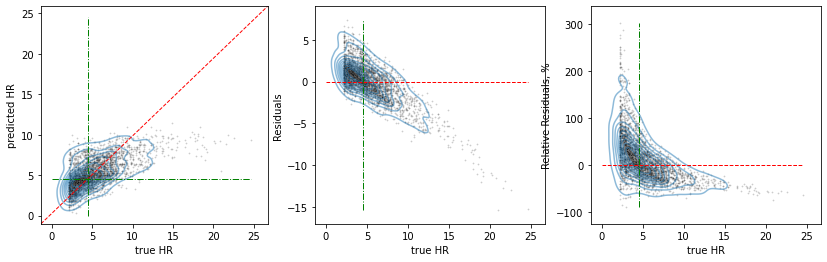

In [50]:
plot_data=test.sample(frac=0.5)
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
sns.scatterplot(ax=ax[0], data=plot_data, x='hourly_rate', y='predicted',  s=3, color='black', alpha=0.2)
sns.kdeplot(ax=ax[0], data=plot_data, x='hourly_rate', y='predicted', alpha=0.5 )
ax[0].set_xlabel('true HR')
ax[0].set_ylabel('predicted HR')
ax[0].set_aspect(aspect=1, adjustable=None, anchor=None, share=False)
ax[0].plot((0,1), (0, 1), transform=ax[0].transAxes, linestyle='--', color='r', lw=1)
ax[0].vlines(ymin=0, ymax=max(test['hourly_rate']) , x=y_train_median, linestyle='-.', color='g', lw=1)
ax[0].hlines(xmin=0, xmax=max(test['hourly_rate']) , y=y_train_median, linestyle='-.', color='g', lw=1)

sns.scatterplot(ax=ax[1], data=plot_data, x='hourly_rate', y='residuals',  s=3, color='black', alpha=0.2)
sns.kdeplot(ax=ax[1], data=plot_data, x='hourly_rate', y='residuals', alpha=0.5 )
ax[1].set_xlabel('true HR')
ax[1].set_ylabel('Residuals')
ax[1].vlines(ymin=min(test['residuals']), ymax=max(test['residuals']) , x=y_train_median, linestyle='-.', color='g', lw=1)
ax[1].hlines(xmin=0, xmax=max(test['hourly_rate']) , y=0, linestyle='--', color='r', lw=1)

sns.scatterplot(ax=ax[2], data=plot_data, x='hourly_rate', y='r_residuals',  s=3, color='black', alpha=0.2)
sns.kdeplot(ax=ax[2], data=plot_data, x='hourly_rate', y='r_residuals', alpha=0.5 )
ax[2].set_xlabel('true HR')
ax[2].set_ylabel('Relative Residuals, %')
ax[2].vlines(ymin=min(test['r_residuals']), ymax=max(test['r_residuals']) , x=y_train_median, linestyle='-.', color='g', lw=1)
ax[2].hlines(xmin=0, xmax=max(test['hourly_rate']) , y=0, linestyle='--', color='r', lw=1);